In [25]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 663.29 GB


In [26]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os

In [27]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [28]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [29]:
tokenizer.get_vocab_size()


544998

In [30]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [31]:
import csv

defense_ips = []
directory = "/home/toibazd/Defense_InterPros/"
file_list = os.listdir(directory)

for file in file_list:
    print(file)
    file_path = os.path.join(directory, file)
    with open(file_path, 'r', newline='') as infile:
        reader = csv.reader(infile, delimiter = "\t")
        next(reader)
        for row in reader:
            ip = row[0]
            defense_ips.append(ip)

LIT_IP.tsv
CRISPR_IP.tsv
BREX_IP.tsv
DISARM_IP.tsv
AbiH_IP.tsv
Kiwa_IP.tsv


In [32]:
print("Defense IPs number: ", len(defense_ips))

Defense IPs number:  120


In [33]:
from collections import defaultdict
import csv
from tqdm.auto import tqdm
import numpy as np

data_dict = defaultdict(list)

with open("/home/toibazd/Prot2IP.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in defense_ips:
                data_dict[key].append(ip)


0it [00:00, ?it/s]

In [34]:
unique_defense = set()

# Iterate through each value list in the dictionary and add its elements to the set
for value_list in data_dict.values():
    unique_defense.update(value_list)

# Convert the set to a list if needed
unique_defense = list(unique_defense)

In [35]:
len(unique_defense)

83

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

661


In [37]:
one_hot_encoded.shape

(661, 83)

In [38]:
import os
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

directory = '/ibex/user/toibazd/InterPro_annotated_genomes/'
one_hot_encoded_sentences = {}

sentence_length = 40
sentences_per_IP = 100

# Set random seed for reproducibility
random.seed(42)

# Randomly choose 1000 files with seed 42
selected_files = os.listdir(directory)


# Define a function to process a file
def process_file(filename, IP):
    sentences = []

    filepath = os.path.join(directory, filename)

    with open(filepath, 'r') as file:
        content = file.read()
        words = content.strip().split()

        # Check if the key is in the file
        for i in range(19, len(words)-20):
            # Shuffle the indices of the words containing the key
            if IP in data_dict[words[i]]:
                if len(words) - i >= 21:
                    sentence = " ".join(words[i - 19:i + sentence_length - 19])
                    sentences.append(sentence)
    return sentences


# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences[IP] = []
    sentences_count = 0

    # Use ThreadPoolExecutor for concurrent processing
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
        for future in futures:
            sentences = future.result()
            one_hot_encoded_sentences[IP].extend(sentences)
            sentences_count += len(sentences)
            if sentences_count >= sentences_per_IP:
                break

    # Break if the required number of sentences per key is reached


100%|██████████| 83/83 [35:35<00:00, 25.73s/it]


In [39]:
for key, values in one_hot_encoded_sentences.items():
    print(len(values))

100
65
100
48
33
100
100
34
25
19
59
18
19
100
100
101
100
100
100
102
100
100
100
51
100
100
100
56
20
100
100
36
84
100
100
100
100
42
106
28
100
101
34
100
100
33
26
19
100
100
49
100
100
100
100
71
33
73
35
16
100
100
27
77
100
100
100
69
100
57
100
100
100
100
17
100
100
100
57
100
100
100
14


In [40]:
import json

with open('BERT_sanity_check_defense_DNN_senteces.json', 'w') as f:
    json.dump(one_hot_encoded_sentences, f)

In [41]:
import json
with open('BERT_sanity_check_defense_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [42]:
for key, value in one_hot_encoded_sentences.items():
    print(key, end=" ")
    print(len(value))

IPR010179 100
IPR013419 65
IPR047939 100
IPR010172 48
IPR049758 33
IPR025935 100
IPR019858 100
IPR013407 34
IPR027620 25
IPR013490 19
IPR013421 59
IPR013487 18
IPR017576 19
IPR013398 100
IPR010144 100
IPR005537 101
IPR019856 100
IPR021124 100
IPR006482 100
IPR002729 102
IPR021127 100
IPR013382 100
IPR047721 100
IPR013410 51
IPR013397 100
IPR013489 100
IPR010147 100
IPR017574 56
IPR013444 20
IPR005510 100
IPR019851 100
IPR049889 36
IPR031820 84
IPR013492 100
IPR010146 100
IPR010173 100
IPR033641 100
IPR049832 42
IPR028629 106
IPR013415 28
IPR013395 100
IPR010148 101
IPR027616 34
IPR010152 100
IPR032359 100
IPR017589 33
IPR047583 26
IPR030955 19
IPR047679 100
IPR019504 100
IPR023844 49
IPR013414 100
IPR013337 100
IPR019857 100
IPR010154 100
IPR048067 71
IPR017575 33
IPR013403 73
IPR027617 35
IPR019117 16
IPR021228 100
IPR013408 100
IPR016581 27
IPR019089 77
IPR019199 100
IPR013381 100
IPR013412 100
IPR023843 69
IPR013418 100
IPR019092 57
IPR013399 100
IPR014858 100
IPR013343 100
IPR01015

In [43]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

83

In [44]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

83

In [45]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

6354

In [46]:
count= 0
for string in matching_string:
    words = string.split(" ")
    if not words[19] in data_dict.keys():
        print("False")
    else:
        count+=1
print(count)

6354


In [47]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-03-11 15:55:50,241] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [48]:
print(one_hot_encoded[1].shape)

(83,)


In [49]:
batch_size = 128 # Define your batch size
embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        labels.append(one_hot_encoded_dict[indicator])

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


100%|██████████| 50/50 [00:01<00:00, 41.41it/s]


In [50]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
      pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
pos_weights = calculate_pos_weights(class_counts) 

In [51]:
pos_weights

tensor([  6.,  55.,  13.,  22.,  62.,  62.,  32.,  38.,  62.,  62.,  26.,  54.,
         62., 452., 116.,  47.,  62.,  62.,  61.,  41.,  62.,  50.,  62.,  62.,
         62.,  62.,  62.,  86., 185.,  62., 118.,  43.,  54.,  30., 225.,  43.,
         93., 106., 316., 351.,  62., 301.,  62.,  62.,  62., 146., 112., 191.,
        333., 191.,  81.,  54., 396.,  30.,  62.,  28.,  58.,  60.,  58.,  59.,
         14.,  46.,  62.,  91., 121.,  62., 185., 180., 253.,  58., 333.,  74.,
         62.,  29., 243.,  62.,  62.,  62.,  88., 191., 372., 150., 175.])

In [52]:
import random

random.seed(42)
# Zip the lists together
combined = list(zip(embeddings, labels))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list
embeddings, labels = zip(*combined)



In [53]:
model.to("cpu")
torch.cuda.empty_cache()

In [54]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = 83
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [55]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels


optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [56]:
import numpy as np

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        outputs = clf_model(batch_embeddings_tensor)
        loss = criterion(outputs, batch_labels_tensor)
#         print(loss)
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")

Epoch 1/20:


1.3359865807571387
Epoch 2/20:


1.0866048678985587
Epoch 3/20:


0.770585265143097
Epoch 4/20:


0.61985067260089
Epoch 5/20:


0.5264051765775696
Epoch 6/20:


0.47548967733073993
Epoch 7/20:


0.4200207443405406
Epoch 8/20:


0.38795119499612385
Epoch 9/20:


0.36819404575634873
Epoch 10/20:


0.33625893117047945
Epoch 11/20:


0.31433431284961216
Epoch 12/20:


0.3180057350329194
Epoch 13/20:


0.30875231268873443
Epoch 14/20:


0.3129297387948905
Epoch 15/20:


0.30986129993682465
Epoch 16/20:


0.3016578997310918
Epoch 17/20:


0.30295338208922284
Epoch 18/20:


0.29656792767662504
Epoch 19/20:


0.2978130709198161
Epoch 20/20:


0.29523387058823597
Training finished.


In [63]:
directory = '/ibex/user/toibazd/InterPro_annotated_genomes_for_testing/'
one_hot_encoded_sentences_2 = {}

sentence_length = 40
sentence_per_IP = 50
selected_files = os.listdir(directory)

total_sentences = sum(len(sentences) for sentences in one_hot_encoded_sentences.values())

# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences_2[IP] = []
    sentences_count=0
    
    # Iterate over selected files
    for filename in selected_files:
        filepath = os.path.join(directory, filename)

        with open(filepath, 'r') as file:
            content = file.read()
            words = content.strip().split()

            # Check if the key is in the file
            for i in range(19, len(words)-20):
                # Shuffle the indices of the words containing the key
                if IP in data_dict[words[i]]:
                    if len(words) - i >= 21:
                        sentence = " ".join(words[i - 19:i + sentence_length - 19])
                        one_hot_encoded_sentences_2[IP].append(sentence)
                        sentences_count += 1
                        if sentences_count>=sentence_per_IP:
                            break
        if sentences_count>=sentence_per_IP:
            break
    print(sentences_count)
            


  1%|          | 1/83 [00:00<00:42,  1.94it/s]

50


  2%|▏         | 2/83 [00:07<05:31,  4.10s/it]

5


  4%|▎         | 3/83 [00:08<03:59,  2.99s/it]

50


  5%|▍         | 4/83 [00:13<04:54,  3.72s/it]

8


  6%|▌         | 5/83 [00:18<05:19,  4.10s/it]

9


  7%|▋         | 6/83 [00:18<03:36,  2.81s/it]

50


  8%|▊         | 7/83 [00:19<02:43,  2.15s/it]

50


 10%|▉         | 8/83 [00:24<03:44,  2.99s/it]

6


 11%|█         | 9/83 [00:29<04:22,  3.55s/it]

9


 12%|█▏        | 10/83 [00:33<04:46,  3.92s/it]

4


 13%|█▎        | 11/83 [00:38<05:03,  4.21s/it]

23


 14%|█▍        | 12/83 [00:45<05:46,  4.88s/it]

2


 16%|█▌        | 13/83 [00:49<05:40,  4.87s/it]

1


 17%|█▋        | 14/83 [00:51<04:20,  3.77s/it]

50


 18%|█▊        | 15/83 [00:51<03:11,  2.81s/it]

50


 19%|█▉        | 16/83 [00:52<02:32,  2.28s/it]

50


 22%|██▏       | 18/83 [00:54<01:33,  1.44s/it]

50
50


 23%|██▎       | 19/83 [00:54<01:13,  1.15s/it]

50
50


 25%|██▌       | 21/83 [00:55<00:43,  1.44it/s]

50


 27%|██▋       | 22/83 [00:55<00:35,  1.72it/s]

50


 28%|██▊       | 23/83 [00:56<00:42,  1.43it/s]

50


 29%|██▉       | 24/83 [01:01<01:46,  1.81s/it]

12


 30%|███       | 25/83 [01:02<01:39,  1.71s/it]

50


 31%|███▏      | 26/83 [01:04<01:35,  1.68s/it]

50


 33%|███▎      | 27/83 [01:04<01:10,  1.26s/it]

50


 34%|███▎      | 28/83 [01:09<02:05,  2.29s/it]

10


 35%|███▍      | 29/83 [01:14<02:43,  3.03s/it]

2


 36%|███▌      | 30/83 [01:16<02:28,  2.80s/it]

50


 37%|███▋      | 31/83 [01:16<01:46,  2.04s/it]

50


 39%|███▊      | 32/83 [01:21<02:26,  2.87s/it]

1


 40%|███▉      | 33/83 [01:26<02:52,  3.45s/it]

27


 41%|████      | 34/83 [01:27<02:18,  2.83s/it]

50


 42%|████▏     | 35/83 [01:29<02:01,  2.53s/it]

50


 43%|████▎     | 36/83 [01:33<02:18,  2.95s/it]

50


 45%|████▍     | 37/83 [01:33<01:38,  2.14s/it]

50


 46%|████▌     | 38/83 [01:38<02:11,  2.92s/it]

7


 47%|████▋     | 39/83 [01:38<01:34,  2.16s/it]

50


 48%|████▊     | 40/83 [01:43<02:06,  2.94s/it]

4


 51%|█████     | 42/83 [01:44<01:12,  1.77s/it]

50
50


 52%|█████▏    | 43/83 [01:49<01:46,  2.67s/it]

10


 53%|█████▎    | 44/83 [01:50<01:17,  1.98s/it]

50


 54%|█████▍    | 45/83 [01:52<01:21,  2.14s/it]

50


 55%|█████▌    | 46/83 [01:57<01:48,  2.93s/it]

4


 57%|█████▋    | 47/83 [02:02<02:05,  3.49s/it]

1


 58%|█████▊    | 48/83 [02:06<02:15,  3.88s/it]

3


 59%|█████▉    | 49/83 [02:08<01:47,  3.15s/it]

50


 60%|██████    | 50/83 [02:13<02:00,  3.65s/it]

32


 61%|██████▏   | 51/83 [02:17<02:07,  3.98s/it]

11


 63%|██████▎   | 52/83 [02:22<02:10,  4.22s/it]

40


 64%|██████▍   | 53/83 [02:27<02:12,  4.40s/it]

25


 65%|██████▌   | 54/83 [02:28<01:40,  3.47s/it]

50


 66%|██████▋   | 55/83 [02:32<01:40,  3.59s/it]

50


 67%|██████▋   | 56/83 [02:37<01:47,  3.97s/it]

16


 69%|██████▊   | 57/83 [02:42<01:50,  4.23s/it]

4


 70%|██████▉   | 58/83 [02:47<01:50,  4.41s/it]

13


 71%|███████   | 59/83 [02:52<01:48,  4.54s/it]

10


 72%|███████▏  | 60/83 [02:56<01:46,  4.62s/it]

3


 73%|███████▎  | 61/83 [02:57<01:18,  3.56s/it]

50


 75%|███████▍  | 62/83 [03:00<01:08,  3.24s/it]

50


 76%|███████▌  | 63/83 [03:05<01:14,  3.71s/it]

4


 78%|███████▊  | 65/83 [03:10<00:51,  2.86s/it]

12
50


 80%|███████▉  | 66/83 [03:10<00:36,  2.12s/it]

50


 81%|████████  | 67/83 [03:12<00:33,  2.09s/it]

50


 82%|████████▏ | 68/83 [03:17<00:43,  2.89s/it]

14


 83%|████████▎ | 69/83 [03:18<00:33,  2.43s/it]

50


 84%|████████▍ | 70/83 [03:23<00:40,  3.13s/it]

8


 86%|████████▌ | 71/83 [03:24<00:30,  2.52s/it]

50


 87%|████████▋ | 72/83 [03:26<00:24,  2.20s/it]

50


 88%|████████▊ | 73/83 [03:26<00:18,  1.81s/it]

50


 89%|████████▉ | 74/83 [03:28<00:15,  1.73s/it]

50


 90%|█████████ | 75/83 [03:33<00:21,  2.65s/it]

4


 92%|█████████▏| 76/83 [03:38<00:23,  3.30s/it]

21


 93%|█████████▎| 77/83 [03:39<00:16,  2.68s/it]

50


 94%|█████████▍| 78/83 [03:42<00:13,  2.76s/it]

50


 95%|█████████▌| 79/83 [03:47<00:13,  3.38s/it]

8


 96%|█████████▋| 80/83 [03:48<00:08,  2.77s/it]

50


 98%|█████████▊| 81/83 [03:48<00:04,  2.07s/it]

50


 99%|█████████▉| 82/83 [03:53<00:02,  2.88s/it]

31


100%|██████████| 83/83 [03:58<00:00,  2.87s/it]

5


In [64]:
for key, value in one_hot_encoded_sentences_2.items():
    print(len(value))

50
5
50
8
9
50
50
6
9
4
23
2
1
50
50
50
50
50
50
50
50
50
50
12
50
50
50
10
2
50
50
1
27
50
50
50
50
7
50
4
50
50
10
50
50
4
1
3
50
32
11
40
25
50
50
16
4
13
10
3
50
50
4
12
50
50
50
14
50
8
50
50
50
50
4
21
50
50
8
50
50
31
5


In [65]:
import json

with open('BERT_sanity_check_defense_DNN_senteces_testing.json', 'w') as f:
    json.dump(one_hot_encoded_sentences_2, f)

In [66]:
with open('BERT_sanity_check_defense_DNN_senteces_testing.json', "r") as f:
    test_sentences = json.load(f)

In [67]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

83

In [68]:
for key, value in test_sentences.items():
    print(key, end=" ")
    print(len(value))

IPR010179 50
IPR013419 5
IPR047939 50
IPR010172 8
IPR049758 9
IPR025935 50
IPR019858 50
IPR013407 6
IPR027620 9
IPR013490 4
IPR013421 23
IPR013487 2
IPR017576 1
IPR013398 50
IPR010144 50
IPR005537 50
IPR019856 50
IPR021124 50
IPR006482 50
IPR002729 50
IPR021127 50
IPR013382 50
IPR047721 50
IPR013410 12
IPR013397 50
IPR013489 50
IPR010147 50
IPR017574 10
IPR013444 2
IPR005510 50
IPR019851 50
IPR049889 1
IPR031820 27
IPR013492 50
IPR010146 50
IPR010173 50
IPR033641 50
IPR049832 7
IPR028629 50
IPR013415 4
IPR013395 50
IPR010148 50
IPR027616 10
IPR010152 50
IPR032359 50
IPR017589 4
IPR047583 1
IPR030955 3
IPR047679 50
IPR019504 32
IPR023844 11
IPR013414 40
IPR013337 25
IPR019857 50
IPR010154 50
IPR048067 16
IPR017575 4
IPR013403 13
IPR027617 10
IPR019117 3
IPR021228 50
IPR013408 50
IPR016581 4
IPR019089 12
IPR019199 50
IPR013381 50
IPR013412 50
IPR023843 14
IPR013418 50
IPR019092 8
IPR013399 50
IPR014858 50
IPR013343 50
IPR010156 50
IPR049794 4
IPR010180 21
IPR013396 50
IPR010149 50
IPR013

In [69]:
matching_string = test_sentences.values()
len(matching_string)

83

In [70]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

2659

In [71]:
from bertviz import model_view

batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]
    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions = True)
    hidden_states = outputs.last_hidden_state
    attentions = outputs.attentions[-1]
    relevant_hidden_states = hidden_states[:, 20, :] 

    
#     for i in range(len(batch_sentences)):
#         if i < 20:
#             att = []
#             extracted_tensor = attentions[i, :, :, :]
#             extracted_tensor = extracted_tensor.unsqueeze(0)
#             print(extracted_tensor.shape)
#             att.append(extracted_tensor)

#             tokens = "[CLS] "+tokenizer.decode(input_ids_list[i])+" [SEP]"
#             tokens = tokens.split(" ")
#             model_view(att, tokens)
    
    for j in range(len(batch_sentences)):

        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        test_labels.append(one_hot_encoded_dict[indicator])


100%|██████████| 21/21 [00:05<00:00,  4.02it/s]


In [72]:
tokenizer.decode([0,12,12,12,12,
                 ])

'WP_072018053 WP_072018053 WP_072018053 WP_072018053'

In [73]:
model.to("cpu")
torch.cuda.empty_cache()

In [74]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=83, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [75]:
generator = data_generator(test_embeddings, test_labels, batch_size)


from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []

for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.85).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


In [76]:
len(all_predictions)

21

In [78]:
len(all_labels[-1])
    

99

In [79]:
print(all_predictions[0].shape)

(128, 83)


In [80]:
print(all_labels[0].shape)

(128, 83)


In [81]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [82]:
all_labels.shape

(2659, 83)

In [83]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("AUC for each column:")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

AUC for each column:
0 :  0.9449853657434091
1 :  0.997315356162749
2 :  0.9677943339515253
3 :  0.9735093410896073
4 :  0.9791184361824454
5 :  0.9840168646991184
6 :  0.9846805275626745
7 :  0.9851960784313725
8 :  0.9998926791874282
9 :  0.9694059026446915
10 :  0.9991414706980217
11 :  0.9919261822376009
12 :  0.9539900344959755
13 :  1.0
14 :  1.0
15 :  1.0
16 :  0.9301418167880413
17 :  0.9999999999999999
18 :  1.0
19 :  0.9218188013478211
20 :  0.9700114986584898
21 :  0.966471781410333
22 :  0.9885473361441165
23 :  0.9889996167113837
24 :  0.9760597930241471
25 :  0.970463779225757
26 :  0.9805366040628593
27 :  0.9998255712541426
28 :  1.0
29 :  1.0
30 :  1.0
31 :  0.9996027079426628
32 :  1.0
33 :  1.0
34 :  1.0
35 :  0.9912959381044487
36 :  1.0
37 :  1.0
38 :  1.0
39 :  1.0
40 :  0.9961441165197393
41 :  1.0
42 :  0.9996473744729781
43 :  1.0
44 :  0.9960061326178613
45 :  1.0
46 :  1.0
47 :  1.0
48 :  1.0
49 :  1.0
50 :  1.0
51 :  1.0
52 :  1.0
53 :  0.9459710824540837
54

In [84]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.9879139554396883


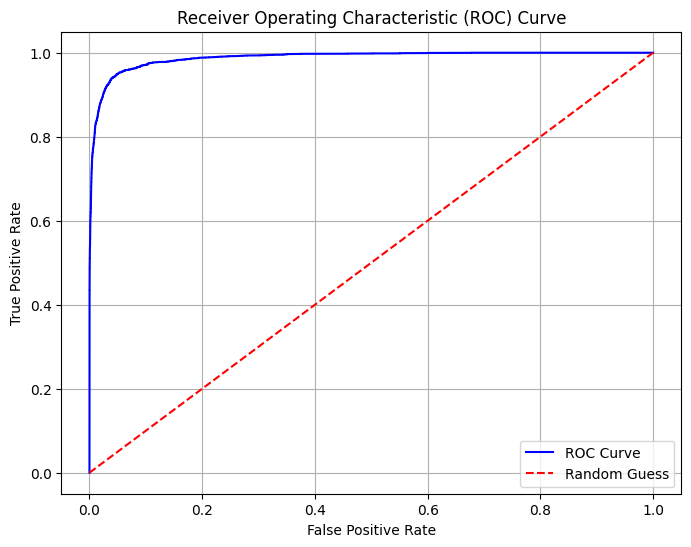

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [86]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
83


In [89]:
print(cl_report[23])

[[2561   48]
 [   8   42]]


In [90]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [91]:
all_predictions.sum(axis=0)

array([173., 140., 129., 117.,  51.,  81.,  75.,  73.,  43.,  40.,  97.,
        60.,  39.,  18.,  21.,  68.,  41.,  21.,  28.,  61.,  89., 122.,
       143.,  90., 121., 106., 105.,  15.,   6.,  49.,  18.,  58.,  18.,
        81.,   4.,  75.,  12.,  29.,   2.,   3.,  35.,   5.,  50.,  56.,
        56.,  77.,  18.,   9.,   1.,   7.,  18.,  17.,   3.,  66.,  66.,
       142.,  51.,  84.,  52.,  42., 108.,  66.,  76.,  29.,  29.,  52.,
        10.,  10.,   9.,  30.,   3.,  27.,  42., 142.,   1.,  29.,  44.,
        47.,  33.,  20.,   5.,   7.,   2.], dtype=float32)

In [92]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.43      0.60       390
           1       0.40      0.97      0.57        58
           2       0.72      0.49      0.58       190
           3       0.64      0.71      0.68       105
           4       0.71      0.72      0.71        50
           5       0.52      0.84      0.64        50
           6       1.00      0.85      0.92        88
           7       0.97      0.95      0.96        75
           8       1.00      0.86      0.92        50
           9       1.00      0.80      0.89        50
          10       0.96      0.99      0.97        94
          11       0.87      0.90      0.88        58
          12       0.82      0.64      0.72        50
          13       0.28      1.00      0.43         5
          14       0.43      1.00      0.60         9
          15       0.97      1.00      0.99        66
          16       0.90      0.74      0.81        50
          17       1.00    

In [93]:
list(enc.classes_)[15]

'IPR010173'

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
num_classes = 83
# Compute precision, recall, and thresholds for each class
precision = dict()
recall = dict()
thresholds = dict()
average_precision = dict()

for i in range(num_classes):  # num_classes is the number of classes
    precision[i], recall[i], thresholds[i] = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
    average_precision[i] = average_precision_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
average_precision["micro"] = average_precision_score(all_labels, all_predictions, average="micro")

# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_predictions[:, i])
    roc_auc[i] = roc_auc_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_predictions.ravel())
roc_auc["micro"] = roc_auc_score(all_labels, all_predictions, average="micro")

# Split classes into groups of 10
class_groups = [list(range(i, min(i + 10, num_classes))) for i in range(0, num_classes, 10)]

# Plot Precision-Recall and ROC curves for each group
for group in class_groups:
    plt.figure(figsize=(12, 6))

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 1)
    plt.step(recall['micro'], precision['micro'], where='post', label='Micro-average Precision-Recall curve (AUPR = {0:0.2f})'
                 ''.format(average_precision["micro"]))
    for i in group:
        plt.step(recall[i], precision[i], where='post', label='Precision-recall curve of class {0} (AUPR = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (Classes {})'.format(group))
    plt.legend(loc="best")

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr['micro'], tpr['micro'], label='Micro-average ROC curve (AUC = {0:0.2f})'
                 ''.format(roc_auc["micro"]))
    for i in group:
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Classes {})'.format(group))
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [1]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.5.
The scikit-learn version is 1.4.1.post1.
